# Classification_data_preprocessing (In Progress)

**Note: the code is still in progress and is subjected to change**

**Dataset_1** : dataset of only annotations
- 25 input columns
- 1 output column (class)

**Dataset_2** : dataset of annotations with their respective geometrical position
- 125 input columns
- 1 output column (class)

## **colab prerequisites and mounting it to drive**

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
pwd

'C:\\Users\\osman\\Desktop\\Final_Model\\Mobilenet\\models_Tf\\research\\object_detection'

In [2]:
cd /content/drive/My Drive/Final_Model/Mobilenet/models_Tf/research/object_detection/

[WinError 3] The system cannot find the path specified: '/content/drive/My Drive/Final_Model/Mobilenet/models_Tf/research/object_detection/'
C:\Users\osman\Desktop\Final_Model\Mobilenet\models_Tf\research\object_detection


## Setting the tensorflow version and enabling the gpu version

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()
#tf.config.list_physical_devices('GPU')


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


## Importing the required libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.svm import LinearSVC
from collections import Counter
from imblearn.base import BaseSampler
from keras import metrics
from sklearn import preprocessing
from sklearn.utils import resample

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [9]:
from keras.constraints import maxnorm

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

## Defining the neural network models required to tune the hyperparameters of the model using "Grid Search technique"

### Model defined for tuning number of epochs and batch size

In [ ]:
def model_1():
    inputs = keras.Input(shape=(25,))
    dense = layers.Dense(64, activation='relu')
    x=dense(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs,outputs=outputs,name="Model_1")
    #model.summary()
    model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])
    return model
    

### Model defined for tuning the optimizer type

In [ ]:
def model_2(optimizer='adam'):
    inputs = keras.Input(shape=(25,))
    dense = layers.Dense(64, activation='relu')
    x=dense(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs,outputs=outputs,name="Model_2")
    #summary = model.summary()
    model.compile(loss='categorical_crossentropy' ,optimizer= optimizer ,metrics=['accuracy'])
    return model
    

### Model defined for tuning the kernel initializers

In [ ]:
def model_3(init_mode='uniform'):
    inputs = keras.Input(shape=(25,))
    dense = layers.Dense(64, activation='relu')
    x=dense(inputs)
    x = layers.Dense(64, kernel_initializer=init_mode, activation='relu')(x)
    x = layers.Dense(32, kernel_initializer=init_mode, activation='relu')(x)
    x = layers.Dense(16, kernel_initializer=init_mode, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs,outputs=outputs,name="Model_3")
    #model.summary()
    model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])
    return model
    

### Model defined for tuning the activation function

In [ ]:
def model_4(activation='relu'):
    inputs = keras.Input(shape=(25,))
    dense = layers.Dense(64, activation=activation)
    x=dense(inputs)
    x = layers.Dense(64, kernel_initializer='uniform', activation=activation)(x)
    x = layers.Dense(32, kernel_initializer='uniform', activation=activation)(x)
    x = layers.Dense(16, kernel_initializer='uniform', activation=activation)(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs,outputs=outputs,name="Model_4")
    #model.summary()
    model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])
    return model
    

### Model defined for tuning number of neurons in each layer

In [ ]:
def model_5(neurons1=1, neurons2=1, neurons3=1):
    inputs = keras.Input(shape=(25,))
    dense = layers.Dense(64, activation='softsign')
    x=dense(inputs)
    x = layers.Dense(neurons1, kernel_initializer='uniform',activation='softsign')(x)
    x = layers.Dense(neurons2, kernel_initializer='uniform',activation='softsign')(x)
    x = layers.Dense(neurons3, kernel_initializer='uniform', activation='softsign')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs,outputs=outputs,name="Model_5")
    #model.summary()
    model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])
    return model
    

### Model defined for tuning the dropout rate and weight constraints

In [ ]:
def model_6(dropout_rate=0.0, weight_constraint=0):
    inputs = keras.Input(shape=(25,))
    dense = layers.Dense(64, activation='relu')
    x=dense(inputs)
    x = layers.Dense(64, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(weight_constraint))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(weight_constraint))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(weight_constraint))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs,outputs=outputs,name="Model_6")
    #model.summary()
    model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])
    return model

## Reading the csv files (Datasets)

In [12]:
data_class=pd.read_csv("class_dataset.csv", index_col=0)
data_pos=pd.read_csv("geo_pos_dataset.csv",index_col=0)
data_both=pd.read_csv("class_geo_dataset.csv", index_col=0)

## Refining and cleaning **Dataset_1** 

In [13]:
data_class

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,oven,range hood,chair,printer,computer,Monitor,Desk,keyboard,Class,image
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,008.jpg
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,100_0281.jpg
2,1,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,100_1412.jpg
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,14_master_bathroom_jl.jpg
4,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,b1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,2,office,office_10.jpg
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2,0,2,office,office_13.jpg
566,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,office,or_02_03_0212_11_l.jpg
567,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,office,or_02_05_0479_11_l.jpg


In [14]:
df4 = data_class[ data_class['Class'] == 'bathroom' ]
df4['night table'].value_counts()
#for data in df4:
 #   data_class['chair']
        

0    97
Name: night table, dtype: int64

In [15]:

df4 = data_class[ data_class['Class'] == 'bed' ].index
for data in df4:
    data_class.loc[data,'Class']='bedroom'
    

In [16]:
data_class.Class.value_counts()

dining room       100
bowling_lounge     98
bedroom            98
bathroom           97
office             97
kitchen            79
Name: Class, dtype: int64

In [17]:
df4= data_class[data_class['Class']=='bedroom'].chair.value_counts()
df4

0    98
Name: chair, dtype: int64

In [18]:
df4 = data_class[ data_class['Class'] == 'bedroom' ].index
counter=0
for data in df4:
    if counter%10==0:
        data_class.loc[data,'chair']+=1
    counter+=1    

In [19]:
df4= data_class[data_class['Class']=='bedroom'].chair.value_counts()
df4

0    88
1    10
Name: chair, dtype: int64

In [20]:
df4= data_class[data_class['Class']=='dining room'].chair.value_counts()
df4

0    100
Name: chair, dtype: int64

In [21]:
df4 = data_class[ data_class['Class'] == 'dining room' ].index
counter=0
for data in df4:
    if counter%20==0:
        data_class.loc[data,'chair']+=1
    counter+=1 

In [22]:
df4 = data_class[ data_class['Class'] == 'dining room' ].index
counter=0
for data in df4:
    if counter%5==0:
        data_class.loc[data,'chair']+=1
    counter+=1 

In [23]:
df4= data_class[data_class['Class']=='dining room'].chair.value_counts()
df4

0    80
1    15
2     5
Name: chair, dtype: int64

## Refining and cleaning **Dataset_2**

In [24]:
data_both

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99,Class
0,1,1,1,1,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
1,1,1,0,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
2,1,1,0,0,2,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
3,1,1,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
4,1,1,0,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,381.016980,0.000000,0.000000,0.000000,0.000000,67.542383,368.135614,139.40678,402.033919,office
565,0,0,0,0,0,0,0,0,0,0,...,490.239557,0.000000,0.000000,0.000000,0.000000,614.717565,456.513013,800.00000,533.000000,office
566,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,office
567,0,0,0,0,0,0,0,0,0,0,...,0.000000,73.871182,150.418079,197.966102,256.000000,0.000000,0.000000,0.00000,0.000000,office


In [25]:
df4 = data_both[ data_both['Class'] == 'bed' ].index
for data in df4:
    data_both.loc[data,'Class']='bedroom'

In [26]:
data_both.Class.value_counts()

dining room       100
bowling_lounge     98
bedroom            98
bathroom           97
office             97
kitchen            79
Name: Class, dtype: int64

In [27]:
df4= data_both[data_both['Class']=='bedroom'].chair.value_counts()
df4

0    98
Name: chair, dtype: int64

In [28]:
df4 = data_both[ data_both['Class'] == 'bedroom' ].index
counter=0
for data in df4:
    if counter%10==0:
        data_both.loc[data,'chair']+=1
    counter+=1    

In [29]:
df4= data_both[data_both['Class']=='bedroom'].chair.value_counts()
df4

0    88
1    10
Name: chair, dtype: int64

In [30]:
df4= data_both[data_both['Class']=='dining room'].chair.value_counts()
df4

0    100
Name: chair, dtype: int64

In [31]:
df4 = data_both[ data_both['Class'] == 'dining room' ].index
counter=0
for data in df4:
    if counter%5==0:
        data_both.loc[data,'chair']+=1
    counter+=1 

In [32]:
df4 = data_both[ data_both['Class'] == 'dining room' ].index
counter=0
for data in df4:
    if counter%20==0:
        data_both.loc[data,'chair']+=1
    counter+=1 

In [33]:
df4= data_both[data_both['Class']=='dining room'].chair.value_counts()
df4

0    80
1    15
2     5
Name: chair, dtype: int64

In [34]:
data_both=data_both.drop(columns='image')

In [35]:
data_both

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99,Class
0,1,1,1,1,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
1,1,1,0,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
2,1,1,0,0,2,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
3,1,1,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
4,1,1,0,1,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,bathroom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,381.016980,0.000000,0.000000,0.000000,0.000000,67.542383,368.135614,139.40678,402.033919,office
565,0,0,0,0,0,0,0,0,0,0,...,490.239557,0.000000,0.000000,0.000000,0.000000,614.717565,456.513013,800.00000,533.000000,office
566,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,office
567,0,0,0,0,0,0,0,0,0,0,...,0.000000,73.871182,150.418079,197.966102,256.000000,0.000000,0.000000,0.00000,0.000000,office


## Upsampling the datasets

### Upsampling **Dataset_1**

In [36]:
upsampled_df = resample(data_class, replace=True, n_samples=3500, random_state=0)
upsampled_df

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,oven,range hood,chair,printer,computer,Monitor,Desk,keyboard,Class,image
559,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,2,0,0,office,office5.jpg
192,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,bedroom,IMG_2430.jpg
359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,dining room,dining10.jpg
9,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,b3.jpg
277,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,bowling_lounge,bowling_0094.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,dining room,dining013.jpg
345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,dining room,dining035.jpg
149,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,bedroom,bed170.jpg
22,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,bathroom,bath26.jpg


In [37]:
upsampled_df=upsampled_df.reset_index(drop=True)

### Upsampling **Dataset_2**

In [38]:
upsampled_df_both = resample(data_both, replace=True, n_samples=3500, random_state=0)
upsampled_df_both

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99,Class
559,0,0,0,0,0,0,0,0,0,0,...,163.145767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,office
192,0,0,0,0,0,1,0,0,1,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bedroom
359,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dining room
9,0,1,1,1,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bathroom
277,0,0,0,0,0,0,0,0,0,4,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bowling_lounge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dining room
345,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dining room
149,0,0,0,0,0,1,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bedroom
22,1,1,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bathroom


In [39]:
upsampled_df_both=upsampled_df_both.reset_index(drop=True)

## Splitting input and output columns

### Splitting input and output columns for **Dataset_1**

**Input**

In [40]:
ips_1=IPS_1=upsampled_df.iloc[:,0:25]
ips_1

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,vase,refrigerator,oven,range hood,chair,printer,computer,Monitor,Desk,keyboard
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,2,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3497,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3498,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Output**

In [41]:
ops_1=OPS_1=upsampled_df.iloc[:,25:26]
ops_1

,Class
0,office
1,bedroom
2,dining room
3,bathroom
4,bowling_lounge
...,...
3495,dining room
3496,dining room
3497,bedroom
3498,bathroom


###  Splitting input and output columns for **Dataset_2**

**Input**

In [42]:
ips_2=IPS_2=upsampled_df_both.iloc[:,0:125]
ips_2

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_90,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99
0,0,0,0,0,0,0,0,0,0,0,...,205.197740,163.145767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,1,0,0,1,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,1,1,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,4,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3496,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3497,0,0,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3498,1,1,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Output**

In [43]:
ops_2=OPS_2=upsampled_df_both.iloc[:,125:]
ops_2

,Class
0,office
1,bedroom
2,dining room
3,bathroom
4,bowling_lounge
...,...
3495,dining room
3496,dining room
3497,bedroom
3498,bathroom


## Splitting the data to train and test

### Splitting for **Dataset_1**

In [74]:
ip_train_1, ip_test_1, op_train_1, op_test_1 = train_test_split(ips_1,ops_1, test_size = 0.10, random_state = 10)

In [ ]:
ip_train_1

In [ ]:
ip_test_1

In [ ]:
op_train_1

In [ ]:
op_test_1

### Splitting for **Dataset_2**

In [75]:
ip_train_2, ip_test_2, op_train_2, op_test_2 = train_test_split(ips_2,ops_2, test_size = 0.10, random_state = 10)

In [ ]:
ip_train_2

In [ ]:
ip_test_2

In [ ]:
op_train_2

In [ ]:
op_test_2

## Create the Labelencoder object (Covernting the classes to numberical label)

### For **Dataset_1**

In [76]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
op_train_1['Class'] = le.fit_transform(op_train_1['Class'])
op_test_1['Class'] = le.fit_transform(op_test_1['Class'])
op_train_1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Class
1708,1
2663,3
494,3
1624,1
1152,1
...,...
3441,4
1344,5
527,2
3197,2


### For **Dataset_2**

In [77]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
op_train_2['Class'] = le.fit_transform(op_train_2['Class'])
op_test_2['Class'] = le.fit_transform(op_test_2['Class'])
op_train_2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Class
1708,1
2663,3
494,3
1624,1
1152,1
...,...
3441,4
1344,5
527,2
3197,2


## Balancing the classification classes of the dataset (Oversampling using SMOTE)

### For **Dataset_1**

In [78]:
op_train_1['Class'].value_counts()

3    568
2    565
1    543
0    535
5    516
4    423
Name: Class, dtype: int64

In [79]:
sm = SMOTE(ratio='all', random_state = 6)
ip_train_1_prep, op_train_1_prep = sm.fit_sample(ip_train_1, op_train_1.values.ravel())
print(sorted(Counter(op_train_1_prep).items()))

[(0, 568), (1, 568), (2, 568), (3, 568), (4, 568), (5, 568)]


In [80]:
ip_train_1_samp=pd.DataFrame(ip_train_1_prep, columns = ip_train_1.columns)

In [81]:
op_train_1_samp=pd.DataFrame(op_train_1_prep, columns = op_train_1.columns)

In [82]:
ip_train_1_samp = ip_train_1_samp.round().astype(int)
ip_train_1_samp

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,vase,refrigerator,oven,range hood,chair,printer,computer,Monitor,Desk,keyboard
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,2,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,2,0,1
3406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [83]:
op_train_1_samp

,Class
0,1
1,3
2,3
3,1
4,1
...,...
3403,5
3404,5
3405,5
3406,5


### For **Dataset_2**

In [84]:
op_train_2['Class'].value_counts()

3    568
2    565
1    543
0    535
5    516
4    423
Name: Class, dtype: int64

In [85]:
sm = SMOTE(ratio='all', random_state = 6)
ip_train_2_prep, op_train_2_prep = sm.fit_sample(ip_train_2, op_train_2.values.ravel())
print(sorted(Counter(op_train_2_prep).items()))

[(0, 568), (1, 568), (2, 568), (3, 568), (4, 568), (5, 568)]


In [86]:
ip_train_2_samp=pd.DataFrame(ip_train_2_prep, columns = ip_train_2.columns)

In [87]:
op_train_2_samp=pd.DataFrame(op_train_2_prep, columns = op_train_2.columns)

In [88]:
ip_train_2_samp = ip_train_2_samp.round().astype(int)
ip_train_2_samp

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_90,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,0,0,0,0,0,0,0,0,0,0,...,0,0,63,79,253,252,0,0,0,0
3404,0,0,0,0,0,0,0,0,0,0,...,92,132,0,0,0,0,0,0,0,0
3405,0,0,0,0,0,0,0,0,0,0,...,145,112,0,0,0,0,68,114,126,128
3406,0,0,0,0,0,0,0,0,0,0,...,0,0,93,125,307,234,0,0,0,0


In [89]:
op_train_2_samp

,Class
0,1
1,3
2,3
3,1
4,1
...,...
3403,5
3404,5
3405,5
3406,5


## Converting the Output data to categorical

### For **Dataset_1**

In [90]:
op_train_1_samp=to_categorical(op_train_1_samp)
op_test_1_cat= to_categorical(op_test_1)

In [91]:
op_train_1_samp

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [92]:
op_test_1_cat

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

### For **Dataset_2**

In [93]:
op_train_2_samp=to_categorical(op_train_2_samp)
op_test_2_cat= to_categorical(op_test_2)

In [94]:
op_train_2_samp

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [95]:
op_test_2_cat

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

## Normalizing the dataset 

### For **Dataset_1**

In [96]:
x = ip_train_1_samp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ip_train_Nor = pd.DataFrame(x_scaled,columns=ip_train_1_samp.columns)

In [97]:
ip_train_Nor

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,vase,refrigerator,oven,range hood,chair,printer,computer,Monitor,Desk,keyboard
0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.333333,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.25,0.0,...,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.50,0.0,...,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,1.0,0.0
3404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.2,0.0,0.0
3405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.25,0.5,0.5,0.4,0.0,0.5
3406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,1.0,0.0


In [98]:
ip_test_1_samp=ip_test_1
x = ip_test_1_samp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ip_test_Nor = pd.DataFrame(x_scaled,columns=ip_test_1_samp.columns)

In [99]:
ip_test_Nor

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,vase,refrigerator,oven,range hood,chair,printer,computer,Monitor,Desk,keyboard
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.5,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.2,1.0,0.5
348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### For **Dataset_2**

In [100]:
x = ip_train_2_samp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_2 = min_max_scaler.fit_transform(x)
ip_train_Nor_2 = pd.DataFrame(x_scaled_2,columns=ip_train_2_samp.columns)

In [101]:
ip_train_Nor_2

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_90,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99
0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.25,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.50,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.049219,0.078373,0.097608,0.129630,0.000000,0.000000,0.000000,0.000000
3404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.043132,0.087649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.067979,0.074369,0.000000,0.000000,0.000000,0.000000,0.059754,0.079944,0.082786,0.073775
3406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.072656,0.124008,0.118441,0.120370,0.000000,0.000000,0.000000,0.000000


In [102]:
ip_test_2_samp=ip_test_2
x = ip_test_2_samp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_2 = min_max_scaler.fit_transform(x)
ip_test_Nor_2 = pd.DataFrame(x_scaled_2,columns=ip_test_2_samp.columns)

In [103]:
ip_test_Nor_2

,mirror,sink,toilet seat,bath tub,towel,bed,dresser cabinet,night table,table lamp,Tv screen,...,val_90,val_91,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.5,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.5,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.081922,0.085093,0.0,0.118914,0.082514,0.130013,0.070532,0.111742,0.082937,0.104465
348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Grid searching to tune the Hyper-parameters of the neural network to choose the optimum values

### Tuning batch size and epochs

In [ ]:

model = KerasClassifier(build_fn=model_1, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100 ]
epochs = [ 10,50, 100, 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=150)
grid_result = grid.fit(ip_train_Nor, op_train_1_samp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Tuning optimizer

In [ ]:

model = KerasClassifier(build_fn=model_2, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta','Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=150)
grid_result = grid.fit(ip_train_Nor, op_train_1_samp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Tuning network weights initialization  

In [ ]:

model = KerasClassifier(build_fn=model_3, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=150)
grid_result = grid.fit(ip_train_Nor, op_train_1_samp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Tuning activation

In [ ]:

model = KerasClassifier(build_fn=model_4, epochs=150, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=150)
grid_result = grid.fit(ip_train_Nor, op_train_1_samp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Tuning number of neurons

In [ ]:

model = KerasClassifier(build_fn=model_5, epochs=150, batch_size=10, verbose=0)
# define the grid search parameters
neurons1 = [5, 10, 20,  30, 50]
neurons2 = [5, 10, 20,  30, 50]
neurons3 = [5, 10, 20,  30, 50]
param_grid = dict(neurons1=neurons1,neurons2=neurons2 )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=150)
grid_result = grid.fit(ip_train_Nor, op_train_1_samp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Tuning the Dropout_rate and weight constraint

In [ ]:
model = KerasClassifier(build_fn=model_6, epochs=150, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3]
dropout_rate = [0.0, 0.2, 0.4, 0.6,0.8]
param_grid = dict(weight_constraint = weight_constraint ,dropout_rate=dropout_rate )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=150)
grid_result = grid.fit(ip_train_Nor, op_train_1_samp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Final models

### Neural Network model for **Dataset_1**

In [ ]:
inputs = keras.Input(shape=(25,))
dense = layers.Dense(64, activation='relu')
x=dense(inputs)
x = layers.Dense(64, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(2))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation='softmax')(x)
    
model = keras.Model(inputs=inputs,outputs=outputs,name="Model_final")
model.summary()
model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])

Model: "Model_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                

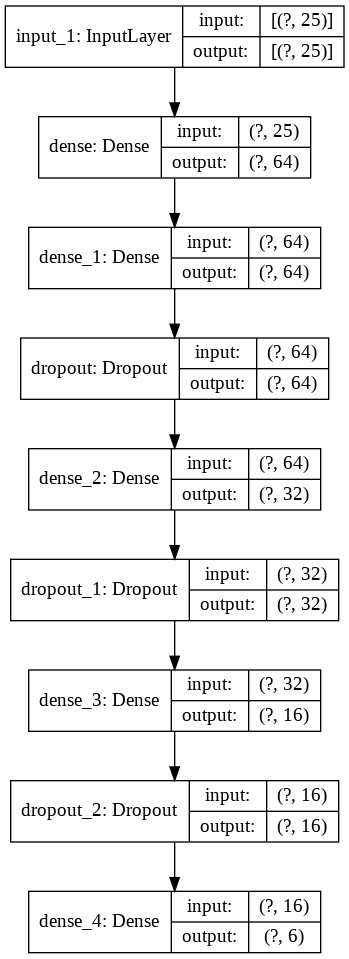

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

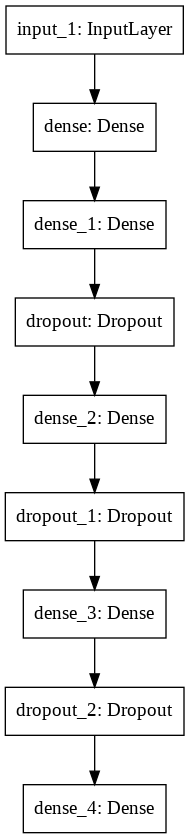

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

In [ ]:
model.fit(ip_train_Nor,op_train_1_samp,epochs= 150, batch_size= 10, verbose=150)

**Accuracy of Train**

In [ ]:
_,train_acc = model.evaluate(ip_train_Nor,op_train_1_samp)
print('Accuracy: %.2f' % (train_acc*100))   

3408/3408 [==============================] - 0s 64us/sample - loss: 0.0188 - acc: 0.9944
Accuracy: 99.44


**Accuracy of Test**

In [ ]:
_,test_acc = model.evaluate(ip_test_Nor,op_test_1_cat)
print('Accuracy: %.2f' % (test_acc*100))

350/350 [==============================] - 0s 86us/sample - loss: 0.0414 - acc: 0.9829
Accuracy: 98.29


In [ ]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
predictions = model.predict(ip_test_1)

Train: 0.994, Test: 0.983


In [ ]:
#predictions = model.predict_classes(ip_test_1)
predictions = model.predict(ip_test_1)
predictions.shape
predictions = np.argmax(predictions, axis=-1)
op_test_1_cat= to_categorical(op_test_1)
op_test_1_cat.shape
op_test_1_cat = np.argmax(op_test_1_cat, axis=-1)

**Sample prediction**

In [ ]:
for i in range(10):
    print('predicted = %d ,(expected = %d)' %(predictions[i], op_test_1_cat[i]))

predicted = 2 ,(expected = 2)
predicted = 1 ,(expected = 1)
predicted = 1 ,(expected = 1)
predicted = 4 ,(expected = 4)
predicted = 1 ,(expected = 1)
predicted = 1 ,(expected = 1)
predicted = 4 ,(expected = 4)
predicted = 2 ,(expected = 2)
predicted = 0 ,(expected = 0)
predicted = 3 ,(expected = 3)


**Confusion Matrix for Dataset_1**

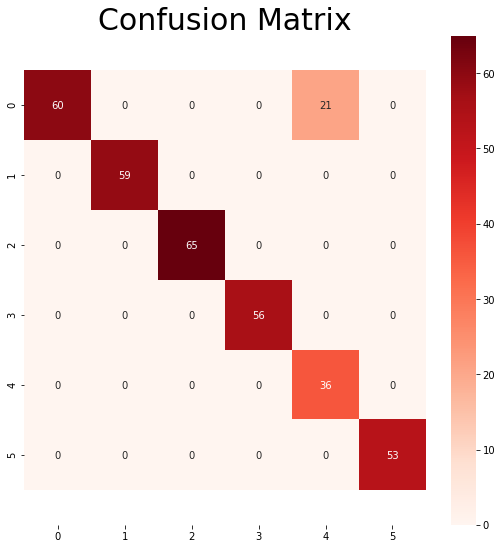

In [ ]:
# creating a confusion matrix
cm = confusion_matrix(predictions, op_test_1_cat)

# printing the confusion matrix
plt.rcParams['figure.figsize'] = (9, 9)
sns.heatmap(cm, annot = True, cmap = 'Reds')
plt.title('Confusion Matrix', fontweight = 20, fontsize = 30)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
plt.show()

**Precision, Recall, F1-score for Dataset_1**

In [ ]:

results = confusion_matrix(op_test_1_cat, predictions) 
print('Accuracy Score :',accuracy_score(op_test_1_cat, predictions)) 
print ('Report : ')
print (classification_report(op_test_1_cat, predictions)) 

Accuracy Score : 0.94
Report : 
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        60
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        56
           4       1.00      0.63      0.77        57
           5       1.00      1.00      1.00        53

    accuracy                           0.94       350
   macro avg       0.96      0.94      0.94       350
weighted avg       0.96      0.94      0.94       350



**Save model**

In [ ]:
model.save("Model_1")

### Neural Network model for **Dataset_2**

In [ ]:
inputs = keras.Input(shape=(125,))
dense = layers.Dense(128, activation='relu')
x=dense(inputs)
x = layers.Dense(64, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, kernel_initializer='uniform', activation='softsign', kernel_constraint=maxnorm(2))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(6, activation='softmax')(x)
    
model = keras.Model(inputs=inputs,outputs=outputs,name="Model_final")
model.summary()
model.compile(loss='categorical_crossentropy' ,optimizer='adam' ,metrics=['accuracy'])

Model: "Model_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16128     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                

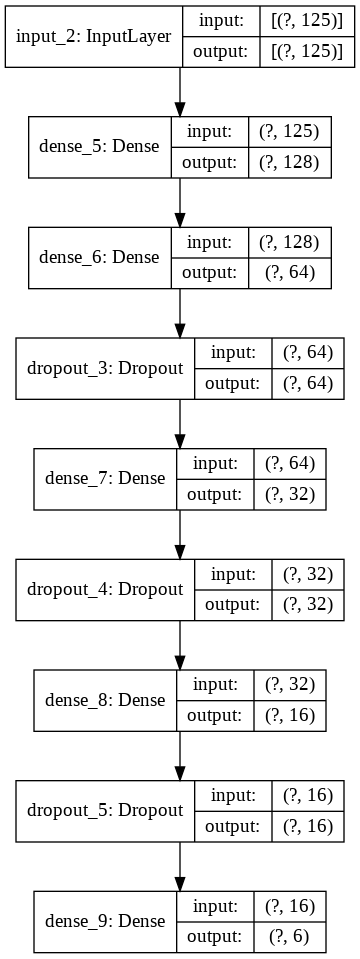

In [ ]:
keras.utils.plot_model(model, "my_second_model_with_shape_info.png", show_shapes=True)

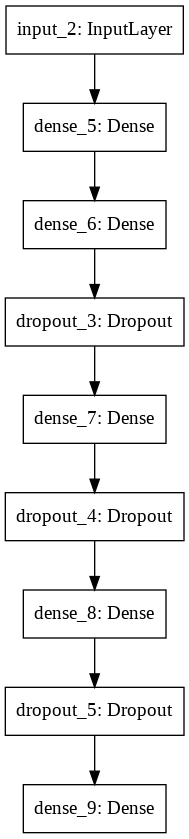

In [ ]:
keras.utils.plot_model(model, "my_second_model.png")

In [ ]:
model.fit(ip_train_Nor_2,op_train_2_samp,epochs= 150, batch_size= 10, verbose=150)

**Accuracy of train and test**

In [ ]:
_,train_acc = model.evaluate(ip_train_Nor_2,op_train_2_samp)
print('Accuracy of train: %.2f' % (train_acc*100))   

_,test_acc = model.evaluate(ip_test_Nor_2,op_test_2_cat)
print('Accuracy of test: %.2f' % (test_acc*100))

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
predictions = model.predict(ip_test_2)

3408/3408 [==============================] - 0s 62us/sample - loss: 0.0000e+00 - acc: 1.0000
Accuracy of train: 100.00
350/350 [==============================] - 0s 56us/sample - loss: 0.0000e+00 - acc: 1.0000
Accuracy of test: 100.00
Train: 1.000, Test: 1.000


**Sample Prediction**

In [ ]:
predictions_2 = model.predict(ip_test_2)
predictions_2.shape
predictions_2 = np.argmax(predictions_2, axis=-1)
op_test_2_cat= to_categorical(op_test_2)
op_test_2_cat.shape
op_test_2_cat = np.argmax(op_test_2_cat, axis=-1)

for i in range(10):
    print('predicted = %d ,(expected = %d)' %(predictions_2[i], op_test_2_cat[i]))

predicted = 2 ,(expected = 2)
predicted = 1 ,(expected = 1)
predicted = 1 ,(expected = 1)
predicted = 4 ,(expected = 4)
predicted = 1 ,(expected = 1)
predicted = 1 ,(expected = 1)
predicted = 4 ,(expected = 4)
predicted = 2 ,(expected = 2)
predicted = 0 ,(expected = 0)
predicted = 3 ,(expected = 3)


**Confusion Matrix for Dataset_2**

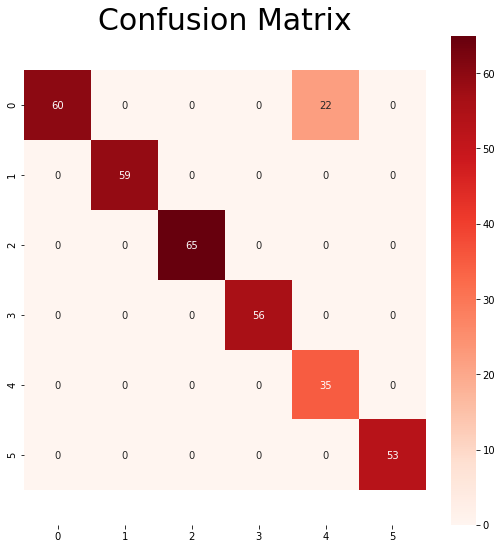

In [ ]:
# creating a confusion matrix
cm = confusion_matrix(predictions_2, op_test_2_cat)

# printing the confusion matrix
plt.rcParams['figure.figsize'] = (9, 9)
sns.heatmap(cm, annot = True, cmap = 'Reds')
plt.title('Confusion Matrix', fontweight = 20, fontsize = 30)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
plt.show()

**Precision, Recall, F1-score for Dataset_2**

In [ ]:
results = confusion_matrix(op_test_2_cat, predictions_2) 
print('Accuracy Score :',accuracy_score(op_test_2_cat, predictions_2)) 
print ('Report : ')
print (classification_report(op_test_2_cat, predictions_2)) 

Accuracy Score : 0.9371428571428572
Report : 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        60
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        56
           4       1.00      0.61      0.76        57
           5       1.00      1.00      1.00        53

    accuracy                           0.94       350
   macro avg       0.96      0.94      0.93       350
weighted avg       0.95      0.94      0.93       350



**Save models**

In [ ]:
model.save("Model_2")

# **Other Algorithm models**

In [104]:
seed = 7
np.random.seed(seed)

In [105]:
# Spot Check Algorithms
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=3, random_state=seed)
	cv_results = model_selection.cross_val_score(model, ip_train_Nor, op_train_1_samp, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

KNN: 0.993545 (0.002196)
CART: 0.994425 (0.001496)


### KNN

In [113]:

#result    
knn = KNeighborsClassifier()
model_knn=knn.fit(ip_train_Nor, op_train_1_samp)
predictions_knn = knn.predict(ip_test_1)
predictions_knn = np.argmax(predictions_knn, axis=-1)
print(accuracy_score(op_test_1, predictions_knn))

0.94


In [ ]:
filename = 'model_knn.sav'
pickle.dump(model_cart, open(filename, 'wb'))

In [114]:
model_knn_2=knn.fit(ip_train_Nor_2, op_train_2_samp)
predictions_knn_2 = knn.predict(ip_test_2)
predictions_knn_2 = np.argmax(predictions_knn_2, axis=-1)
print(accuracy_score(op_test_2, predictions_knn_2))

0.9228571428571428


In [ ]:
filename = 'model_knn_2.sav'
pickle.dump(model_cart, open(filename, 'wb'))

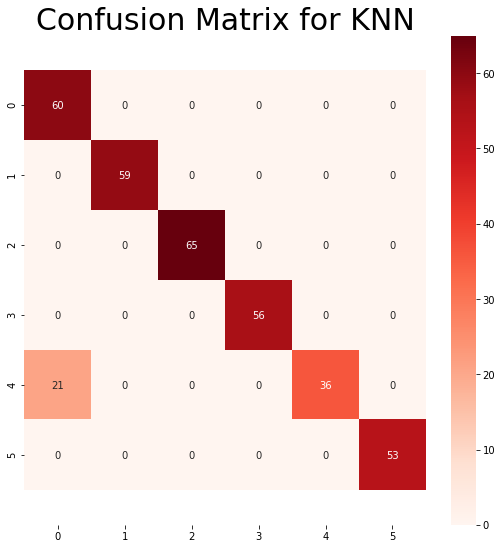

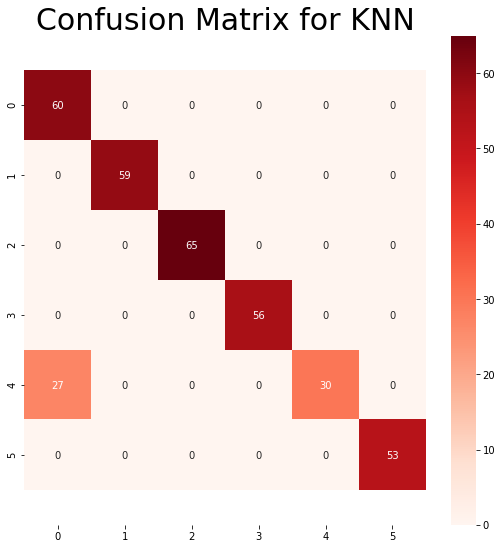

In [115]:
# creating a confusion matrix
cm = confusion_matrix(op_test_1, predictions_knn)
cm_2 = confusion_matrix(op_test_2, predictions_knn_2)
# printing the confusion matrix
plt.rcParams['figure.figsize'] = (9, 9)
sns.heatmap(cm, annot = True, cmap = 'Reds')
plt.title('Confusion Matrix for KNN', fontweight = 20, fontsize = 30)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
plt.show()

sns.heatmap(cm_2, annot = True, cmap = 'Reds')
plt.title('Confusion Matrix for KNN', fontweight = 20, fontsize = 30)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
plt.show()

In [116]:
results = confusion_matrix(op_test_1, predictions_knn)
print ('Accuracy Score :', accuracy_score(op_test_1, predictions_knn))
print ('Report : ')
print (classification_report(op_test_1, predictions_knn))

Accuracy Score : 0.94
Report : 
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        60
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        56
           4       1.00      0.63      0.77        57
           5       1.00      1.00      1.00        53

    accuracy                           0.94       350
   macro avg       0.96      0.94      0.94       350
weighted avg       0.96      0.94      0.94       350



In [117]:
results = confusion_matrix(op_test_2, predictions_knn_2)
print ('Accuracy Score :', accuracy_score(op_test_2, predictions_knn_2))
print ('Report : ')
print (classification_report(op_test_2, predictions_knn_2))

Accuracy Score : 0.9228571428571428
Report : 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        60
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        56
           4       1.00      0.53      0.69        57
           5       1.00      1.00      1.00        53

    accuracy                           0.92       350
   macro avg       0.95      0.92      0.92       350
weighted avg       0.95      0.92      0.92       350



### CART

In [120]:
#result    
Cart = DecisionTreeClassifier()
model_cart=Cart.fit(ip_train_Nor, op_train_1_samp)
predictions_cart = Cart.predict(ip_test_1)
predictions_cart = np.argmax(predictions_cart, axis=-1)
print(accuracy_score(op_test_1, predictions_cart))

0.9371428571428572


In [ ]:
filename = 'model_knn_1.sav'
pickle.dump(model_cart, open(filename, 'wb'))

In [121]:
#result    
#Cart = DecisionTreeClassifier()
model_cart_1=Cart.fit(ip_train_Nor_2, op_train_2_samp)
predictions_cart_2 = Cart.predict(ip_test_2)
predictions_cart_2 = np.argmax(predictions_cart_2, axis=-1)
print(accuracy_score(op_test_2, predictions_cart_2))

0.9371428571428572


In [ ]:
filename = 'model_knn_1.sav'
pickle.dump(model_cart_1, open(filename, 'wb'))

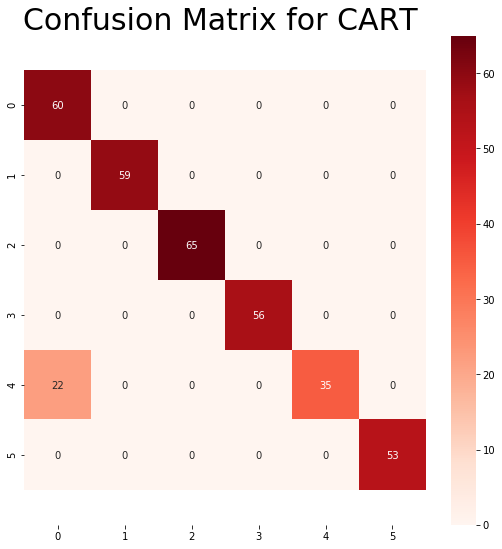

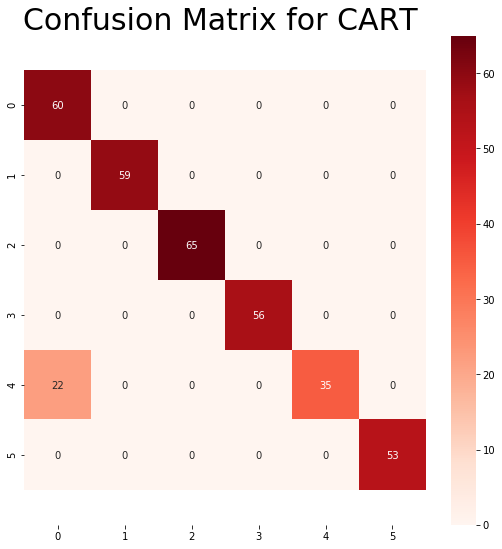

In [123]:
# creating a confusion matrix
cm = confusion_matrix(op_test_1, predictions_cart)
cm_2 = confusion_matrix(op_test_2, predictions_cart_2)

# printing the confusion matrix
plt.rcParams['figure.figsize'] = (9, 9)
sns.heatmap(cm, annot = True, cmap = 'Reds')
plt.title('Confusion Matrix for CART ', fontweight = 20, fontsize = 30)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
plt.show()

sns.heatmap(cm_2, annot = True, cmap = 'Reds')
plt.title('Confusion Matrix for CART ', fontweight = 20, fontsize = 30)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
plt.show()

In [124]:
results = confusion_matrix(op_test_1, predictions_cart)
print ('Accuracy Score :', accuracy_score(op_test_1, predictions_cart))
print ('Report : ')
print (classification_report(op_test_1, predictions_cart))

Accuracy Score : 0.9371428571428572
Report : 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        60
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        56
           4       1.00      0.61      0.76        57
           5       1.00      1.00      1.00        53

    accuracy                           0.94       350
   macro avg       0.96      0.94      0.93       350
weighted avg       0.95      0.94      0.93       350



In [125]:
results = confusion_matrix(op_test_2, predictions_cart_2)
print ('Accuracy Score :', accuracy_score(op_test_2, predictions_cart_2))
print ('Report : ')
print (classification_report(op_test_2, predictions_cart_2))

Accuracy Score : 0.9371428571428572
Report : 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        60
           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        56
           4       1.00      0.61      0.76        57
           5       1.00      1.00      1.00        53

    accuracy                           0.94       350
   macro avg       0.96      0.94      0.93       350
weighted avg       0.95      0.94      0.93       350

